# OSNAP line Lagrangian particle tracking investigation of the cold/fresh blob


### The aim here is an investigation of the source of the cold/fresh blob which appeared in the near-surface Iceland Basin from about 2014. There are a couple of published explanations for the feature: 

- reduced heat/salt transport across RAPID array and northwards to subpolar N Atlantic over several years (Bryden et al. 2020?) or 
- increased contribution from Labrador Sea water flowing into subpolar North Atlantic rather than southwards (Holliday et al. 2020?). Driven I think by specific,  more intermittent, weather near Flemish Cap (though I need to read this again...)

The technique is to track particles back from the OSNAP line for 4 years and identify those which came from the Gulf Stream and those which came through the Labrador Sea. And see how that changes between from 2006 to 2017. (Elsewhere I have done backwards particle tracking for all years between 2006 and 2017. This supports the results shown here and adds some detail, but 2 years tracking isn't really long enough to identify pathways). I am also trying to quantify the volume/heat/salt transports along each route (not here yet though).

## This notebook calculates histograms of transit times

## Technical preamble

In [1]:
# import matplotlib.colors as colors
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
import seaborn as sns
# from matplotlib.colors import ListedColormap
import cmocean as co
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import cartopy.crs as ccrs
import cartopy
import seawater as sw
from xhistogram.xarray import histogram


from matplotlib import colors as c
from matplotlib import ticker
# from xhistogram.xarray import histogram

In [2]:
from dask.distributed import Client

In [3]:
client = Client(n_workers=1, threads_per_worker=8, memory_limit=32e9)
client

/opt/tljh/user/envs/parcels-container_2021.09.29-09ab0ce/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42865 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/workshop007/proxy/42865/status,
Dashboard: /user/workshop007/proxy/42865/status,Workers: 1
Total threads: 8,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38407,Workers: 1
Dashboard: /user/workshop007/proxy/42865/status,Total threads: 8
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://134.245.214.97:46343,Total threads: 8
Dashboard: /user/workshop007/proxy/33055/status,Memory: 29.80 GiB
Nanny: tcp://127.0.0.1:43575,


In [4]:
sns.set(style="whitegrid")

xr.set_options(keep_attrs=True)
np.warnings.filterwarnings('ignore')

sns.set_palette("colorblind")
xr.set_options(keep_attrs=True);

plt.rc('font', size=14) #controls default text size
plt.rc('axes', titlesize=14) #fontsize of the title
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend
plt.rc('savefig', dpi=300)       # higher res outputs

## Set up paths and read in trajectory data

In [5]:
# parameters
project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

interim_data_path = Path('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/endtracks/plusDist/')

outputPath = Path('data/processed/transitTimes/noNorth/')
output_data_path = project_path / outputPath

sectionPath = Path('data/external/')
sectionFilename = 'osnap_pos_wp.txt'
sectionname = 'osnap'

year = 2000
nsubsets = 32


In [6]:
yearstr = str(year)

In [7]:
degree2km = 1.852*60.0

## Load endtrack data

We'll first find all the relevant files and then open them as a virtual contiguous dataset.

In [8]:
# data_stores_subsets = list(sorted(Path(data_path).glob("*_????_subset.zarr/")))[:use_number_subset_years]
data_trackends_subsets = list(sorted(Path(interim_data_path).glob(f"*.nc/")))


In [9]:
print(data_trackends_subsets)

[PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/endtracks/plusDist/endtracks_20211215_randomvel_mxl_osnap_backwards_1990.nc'), PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/endtracks/plusDist/endtracks_20211215_randomvel_mxl_osnap_backwards_1991.nc'), PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/endtracks/plusDist/endtracks_20211215_randomvel_mxl_osnap_backwards_1992.nc'), PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/endtracks/plusDist/endtracks_20211215_randomvel_mxl_osnap_backwards_1993.nc'), PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/endtracks/plusDist/endtracks_20211215_randomvel_mxl_osnap_backwards_1994.nc'), PosixPath('/data/spg_fresh_blob_202104_data/2022-02-27_wr-final-runs/data/interim/endtracks/plusDist/endtracks_20211215_randomvel_mxl_osnap_backwards_1995.nc'), PosixPath('/data/spg_fresh_blob_2

In [10]:
ds = xr.concat(
    [xr.open_dataset(store,chunks={
        "ends": 2, "traj": 1048576
    }) for store in data_trackends_subsets],
    dim="traj",
)
# ds = xr.concat(
#     [xr.open_dataset(store) for store in data_trackends_subsets],
#     dim="traj",
# )

display(ds)
print(ds.nbytes / 1e9, "GiB")

<xarray.Dataset>
Dimensions:          (traj: 141430659, ends: 2)
Dimensions without coordinates: traj, ends
Data variables: (12/20)
    obs2d            (traj) float64 dask.array<chunksize=(1048576,), meta=np.ndarray>
    lat              (ends, traj) float32 dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    lon              (ends, traj) float32 dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    mxl              (ends, traj) float32 dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    salt             (ends, traj) float32 dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    temp             (ends, traj) float32 dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    ...               ...
    GulfS_is_source  (ends, traj) bool dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    other_is_source  (ends, traj) bool dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    Green_is_source  (ends, traj) bool dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    Davis_is_source  (ends, traj) bool dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    Hudba_is_source  (ends, traj) bool dask.array<chunksize=(2, 1048576), meta=np.ndarray>
    north_of_osnap   (ends, traj) bool dask.array<chunksize=(2, 1048576), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

16.123095126 GiB


In [11]:
len(ds.traj) % 32

3

### section position data -- need this for orientation of sections

In [12]:
lonlat = xr.Dataset(pd.read_csv(project_path / sectionPath / sectionFilename,delim_whitespace=True))

In [13]:
lonlat.lon.attrs['long_name']='Longitude'
lonlat.lat.attrs['long_name']='Latitude'
lonlat.lon.attrs['standard_name']='longitude'
lonlat.lat.attrs['standard_name']='latitude'
lonlat.lon.attrs['units']='degrees_east'
lonlat.lat.attrs['units']='degrees_north'

lonlat2mean= lonlat.rolling({'dim_0':2}).mean()

lonlatdiff = (lonlat.diff('dim_0'))

lonlatdiff = lonlatdiff.assign({'y':lonlatdiff['lat']*degree2km})
lonlatdiff = lonlatdiff.assign({'x':lonlatdiff['lon']*degree2km*np.cos(np.radians(lonlat2mean.lat.data[1:]))})
lonlatdiff=lonlatdiff.assign({'length':np.sqrt(lonlatdiff['x']**2+lonlatdiff['y']**2)})
lonlatdiff=lonlatdiff.assign({'costheta':lonlatdiff['x']/lonlatdiff['length']})
lonlatdiff=lonlatdiff.assign({'sintheta':lonlatdiff['y']/lonlatdiff['length']})

total_length = lonlatdiff.length.sum().data 
total_osnap_length = lonlatdiff.length[0:12].sum().data;  # exclude section across UK - just there for testing north/south

length_west = xr.concat((xr.DataArray([0],dims=("dim_0"),coords={"dim_0": [0]}),lonlatdiff.length.cumsum()),dim='dim_0')

In [14]:
lonlat

<xarray.Dataset>
Dimensions:  (dim_0: 13)
Coordinates:
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    lat      (dim_0) float64 52.09 52.67 53.59 59.11 ... 57.99 57.47 57.1 56.73
    lon      (dim_0) float64 -56.16 -52.1 -49.78 -47.34 ... -12.71 -9.275 -5.77

#### Subset tracks by OSNAP line cross longitude and depth range

In [15]:
lonRange=[-37,0]
depthRange=[0,500]
range_str = 'OsnapE_37W_0_500m'

In [16]:
ds = ds.where((ds.isel(ends=0).lon > lonRange[0]) & (ds.isel(ends=0).lon < lonRange[1]))
ds = ds.where((ds.isel(ends=0).z > depthRange[0]) & (ds.isel(ends=0).z < depthRange[1]))
ds = ds.where(ds.isel(ends=0).north_of_osnap == False)
ds = ds.dropna('traj', how='all')    

In [17]:
ds


<xarray.Dataset>
Dimensions:          (traj: 27277570, ends: 2)
Dimensions without coordinates: traj, ends
Data variables: (12/20)
    obs2d            (traj) float64 dask.array<chunksize=(205240,), meta=np.ndarray>
    lat              (ends, traj) float32 dask.array<chunksize=(2, 205240), meta=np.ndarray>
    lon              (ends, traj) float32 dask.array<chunksize=(2, 205240), meta=np.ndarray>
    mxl              (ends, traj) float32 dask.array<chunksize=(2, 205240), meta=np.ndarray>
    salt             (ends, traj) float32 dask.array<chunksize=(2, 205240), meta=np.ndarray>
    temp             (ends, traj) float32 dask.array<chunksize=(2, 205240), meta=np.ndarray>
    ...               ...
    GulfS_is_source  (ends, traj) float64 dask.array<chunksize=(2, 205240), meta=np.ndarray>
    other_is_source  (ends, traj) float64 dask.array<chunksize=(2, 205240), meta=np.ndarray>
    Green_is_source  (ends, traj) float64 dask.array<chunksize=(2, 205240), meta=np.ndarray>
    Davis_is_source  (ends, traj) float64 dask.array<chunksize=(2, 205240), meta=np.ndarray>
    Hudba_is_source  (ends, traj) float64 dask.array<chunksize=(2, 205240), meta=np.ndarray>
    north_of_osnap   (ends, traj) float64 dask.array<chunksize=(2, 205240), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

#### Velocity conversions from degrees lat/lon per second to m/s

In [18]:
ds=ds.assign({'uvel_ms':ds.uvel * degree2km * 1000.0 * np.cos(np.radians(ds.lat))})
ds=ds.assign({'vvel_ms':ds.vvel * degree2km * 1000.0})

In [19]:
ds = ds.assign({'section_index':(ds.isel(ends=0).lon > lonlat.lon).sum(dim='dim_0')-1})

In [20]:
costheta = lonlatdiff.costheta[ds.section_index]
sintheta = lonlatdiff.sintheta[ds.section_index]

In [21]:
ds = ds.assign({'u_normal':ds.isel(ends=0).vvel_ms * costheta - 
                           ds.isel(ends=0).uvel_ms * sintheta})
ds = ds.assign({'u_along':ds.isel(ends=0).vvel_ms * sintheta + 
                          ds.isel(ends=0).uvel_ms * costheta})

In [22]:
ds = ds.where(ds.isel(ends=0).u_normal >= 0.0)
ds = ds.dropna('traj', how='all')

In [23]:
ds = ds.drop(labels=['obs2d',
                     'lat',
                    'lon',
                    'z',
                    'mxl',
                    'temp',
                    'salt',
                    'uvel',
                    'vvel',
                    'north_of_osnap',
                    'uvel_ms',
                    'vvel_ms',
                    'Green_is_source',
                    'Hudba_is_source',
                    'dist',
                    'section_index',
                    'u_normal',
                    'u_along'])

In [24]:
ds

<xarray.Dataset>
Dimensions:          (ends: 2, traj: 24813445)
Coordinates:
    dim_0            (traj) int64 6 6 6 6 6 6 6 6 6 ... 12 12 12 12 12 12 12 12
Dimensions without coordinates: ends, traj
Data variables:
    time             (ends, traj) datetime64[ns] dask.array<chunksize=(2, 183607), meta=np.ndarray>
    LabCu_is_source  (ends, traj) float64 dask.array<chunksize=(2, 183607), meta=np.ndarray>
    LC60W_is_path    (ends, traj) float64 dask.array<chunksize=(2, 183607), meta=np.ndarray>
    LCdir_is_path    (ends, traj) float64 dask.array<chunksize=(2, 183607), meta=np.ndarray>
    GulfS_is_source  (ends, traj) float64 dask.array<chunksize=(2, 183607), meta=np.ndarray>
    other_is_source  (ends, traj) float64 dask.array<chunksize=(2, 183607), meta=np.ndarray>
    Davis_is_source  (ends, traj) float64 dask.array<chunksize=(2, 183607), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

In [25]:
deltaT = -1*ds.time.diff(dim='ends').squeeze()
ds["deltaT"]=deltaT

In [26]:
ds

<xarray.Dataset>
Dimensions:          (ends: 2, traj: 24813445)
Coordinates:
    dim_0            (traj) int64 6 6 6 6 6 6 6 6 6 ... 12 12 12 12 12 12 12 12
Dimensions without coordinates: ends, traj
Data variables:
    time             (ends, traj) datetime64[ns] dask.array<chunksize=(2, 183607), meta=np.ndarray>
    LabCu_is_source  (ends, traj) float64 dask.array<chunksize=(2, 183607), meta=np.ndarray>
    LC60W_is_path    (ends, traj) float64 dask.array<chunksize=(2, 183607), meta=np.ndarray>
    LCdir_is_path    (ends, traj) float64 dask.array<chunksize=(2, 183607), meta=np.ndarray>
    GulfS_is_source  (ends, traj) float64 dask.array<chunksize=(2, 183607), meta=np.ndarray>
    other_is_source  (ends, traj) float64 dask.array<chunksize=(2, 183607), meta=np.ndarray>
    Davis_is_source  (ends, traj) float64 dask.array<chunksize=(2, 183607), meta=np.ndarray>
    deltaT           (traj) timedelta64[ns] dask.array<chunksize=(183607,), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

In [27]:
tail = len(ds.traj) % 32
ds_subsets = xr.concat(
    [ds.isel(traj=slice(subsetno,-tail,nsubsets))
     for subsetno in range(0,nsubsets)],
    dim="subsetno",
)

In [28]:
ds_subsets

,Array,Chunk
Bytes,378.62 MiB,111.94 kiB
Shape,"(32, 2, 775420)","(1, 2, 7164)"
Count,47468 Tasks,9632 Chunks
Type,datetime64[ns],numpy.ndarray
,Array,Chunk
Bytes,378.62 MiB,111.94 kiB
Shape,"(32, 2, 775420)","(1, 2, 7164)"
Count,47619 Tasks,9632 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [30]:
ds_subsets = ds_subsets.isel(ends=0).compute()

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [34]:
ds_subsets = ds_subsets.chunk(chunks={'subsetno':1,'traj':1000000})

In [31]:
deltaT = ds_subsets.deltaT

In [32]:
dstime = ds_subsets.time

In [33]:
deltaT_1990s = deltaT.where(dstime < np.datetime64('2000-01-01T00:00:00'))

In [34]:
deltaT_2000s = deltaT.where((dstime > np.datetime64('2000-01-01T00:00:00')) &
                        (dstime < np.datetime64('2010-01-01T00:00:00')))


In [35]:
deltaT_2010s = deltaT.where((dstime > np.datetime64('2010-01-01T00:00:00')) &
                        (dstime < np.datetime64('2020-01-01T00:00:00')))


In [36]:
deltaT_1990s

<xarray.DataArray 'deltaT' (subsetno: 32, traj: 775420)>
array([[175824000000000000,  68688000000000000,  47520000000000000, ...,
                     'NaT',              'NaT',              'NaT'],
       [ 99360000000000000, 231552000000000000,  99792000000000000, ...,
                     'NaT',              'NaT',              'NaT'],
       [ 57456000000000000, 128736000000000000, 200880000000000000, ...,
                     'NaT',              'NaT',              'NaT'],
       ...,
       [ 60048000000000000,  75600000000000000,  39744000000000000, ...,
                     'NaT',              'NaT',              'NaT'],
       [315360000000000000,  66960000000000000, 139104000000000000, ...,
                     'NaT',              'NaT',              'NaT'],
       [172368000000000000, 203904000000000000,  75168000000000000, ...,
                     'NaT',              'NaT',              'NaT']],
      dtype='timedelta64[ns]')
Coordinates:
    dim_0    (subsetno, traj) int64 6 6 6 6 6 6 6 6 ... 12 12 12 12 12 12 12 12
Dimensions without coordinates: subsetno, traj
Attributes:
    axis:           T
    long_name:      
    standard_name:  time

In [37]:
bins = np.linspace(0,3650,731)

In [38]:
h_total = histogram(deltaT.dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_labcu = histogram(deltaT.where(ds_subsets.LabCu_is_source).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_gulfs = histogram(deltaT.where(ds_subsets.GulfS_is_source).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()

In [39]:
h_total_1990s = histogram(deltaT_1990s.dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_labcu_1990s = histogram(deltaT_1990s.where(ds_subsets.LabCu_is_source).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_gulfs_1990s = histogram(deltaT_1990s.where(ds_subsets.GulfS_is_source).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()

In [40]:
h_total_2000s = histogram(deltaT_2000s.dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_labcu_2000s = histogram(deltaT_2000s.where(ds_subsets.LabCu_is_source).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_gulfs_2000s = histogram(deltaT_2000s.where(ds_subsets.GulfS_is_source).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()

In [41]:
h_total_2010s = histogram(deltaT_2010s.dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_labcu_2010s = histogram(deltaT_2010s.where(ds_subsets.LabCu_is_source).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_gulfs_2010s = histogram(deltaT_2010s.where(ds_subsets.GulfS_is_source).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()

In [42]:
def plot_hist_curve(ax,h,color,linestyle,nyears,label='',ntraj=1):
    h_mean = h.isel(days_bin=slice(0,-1,1)).mean(dim='subsetno')*100.0/ntraj
    h_std =  h.isel(days_bin=slice(0,-1,1)).std(dim='subsetno')*100.0/ntraj
    h_mean.plot(ax=ax,
                color=color,
                linestyle=linestyle,
                label=label)
    ax.fill_between(h_mean.days_bin,
                    h_mean+1.96*h_std,
                    h_mean-1.96*h_std,
                    color=color,
                    linewidth=0,
                    zorder=1,
                    alpha=0.2)
    return


In [43]:
ntraj_total = h_total.sum(dim='days_bin').mean(dim='subsetno')


Text(0, 0.5, 'percentage of particle')

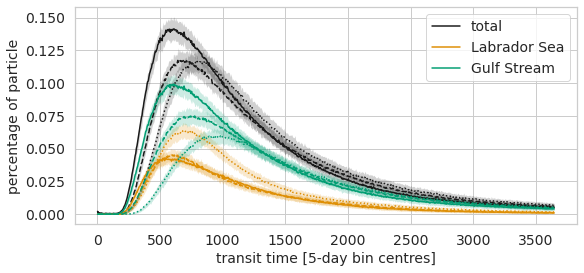

In [44]:
fig,ax = plt.subplots(1,figsize = (9,4),sharex=True)


plot_hist_curve(ax,h_total_1990s,'k','solid',10,'total',ntraj=ntraj_total)
plot_hist_curve(ax,h_total_2000s,'k','dashed',10,ntraj=ntraj_total)
plot_hist_curve(ax,h_total_2010s,'k','dotted',10,ntraj=ntraj_total)

plot_hist_curve(ax,h_labcu_1990s,'C1','solid',10,'Labrador Sea',ntraj=ntraj_total)
plot_hist_curve(ax,h_labcu_2000s,'C1','dashed',10,ntraj=ntraj_total)
plot_hist_curve(ax,h_labcu_2010s,'C1','dotted',10,ntraj=ntraj_total)

plot_hist_curve(ax,h_gulfs_1990s,'C2','solid',10,'Gulf Stream',ntraj=ntraj_total)
plot_hist_curve(ax,h_gulfs_2000s,'C2','dashed',10,ntraj=ntraj_total)
plot_hist_curve(ax,h_gulfs_2010s,'C2','dotted',10,ntraj=ntraj_total)

ax.legend()
ax.set_xlabel('transit time [5-day bin centres]')
ax.set_ylabel('percentage of particle')


In [45]:
h_lc60w = histogram(deltaT.where(ds_subsets.LC60W_is_path).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_lcdir = histogram(deltaT.where(ds_subsets.LCdir_is_path).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()

In [46]:
h_lc60w_1990s = histogram(deltaT_1990s.where(ds_subsets.LC60W_is_path).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_lcdir_1990s = histogram(deltaT_1990s.where(ds_subsets.LCdir_is_path).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()

In [47]:
h_lc60w_2000s = histogram(deltaT_2000s.where(ds_subsets.LC60W_is_path).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_lcdir_2000s = histogram(deltaT_2000s.where(ds_subsets.LCdir_is_path).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()

In [48]:
h_lc60w_2010s = histogram(deltaT_2010s.where(ds_subsets.LC60W_is_path).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()
h_lcdir_2010s = histogram(deltaT_2010s.where(ds_subsets.LCdir_is_path).dt.days,
                    bins=[bins],
                    dim=['traj']
                   ).compute()

In [49]:
h_total.to_netcdf(output_data_path / 'histogram_transit_time_total_all.nc')
h_total_1990s.to_netcdf(output_data_path / 'histogram_transit_time_total_1990s.nc')
h_total_2000s.to_netcdf(output_data_path / 'histogram_transit_time_total_2000s.nc')
h_total_2010s.to_netcdf(output_data_path / 'histogram_transit_time_total_2010s.nc')

h_labcu.to_netcdf(output_data_path / 'histogram_transit_time_labcu_all.nc')
h_labcu_1990s.to_netcdf(output_data_path / 'histogram_transit_time_labcu_1990s.nc')
h_labcu_2000s.to_netcdf(output_data_path / 'histogram_transit_time_labcu_2000s.nc')
h_labcu_2010s.to_netcdf(output_data_path / 'histogram_transit_time_labcu_2010s.nc')

h_gulfs.to_netcdf(output_data_path / 'histogram_transit_time_gulfs_all.nc')
h_gulfs_1990s.to_netcdf(output_data_path / 'histogram_transit_time_gulfs_1990s.nc')
h_gulfs_2000s.to_netcdf(output_data_path / 'histogram_transit_time_gulfs_2000s.nc')
h_gulfs_2010s.to_netcdf(output_data_path / 'histogram_transit_time_gulfs_2010s.nc')

h_lc60w.to_netcdf(output_data_path / 'histogram_transit_time_lc60w_all.nc')
h_lc60w_1990s.to_netcdf(output_data_path / 'histogram_transit_time_lc60w_1990s.nc')
h_lc60w_2000s.to_netcdf(output_data_path / 'histogram_transit_time_lc60w_2000s.nc')
h_lc60w_2010s.to_netcdf(output_data_path / 'histogram_transit_time_lc60w_2010s.nc')

h_lcdir.to_netcdf(output_data_path / 'histogram_transit_time_lcdir_all.nc')
h_lcdir_1990s.to_netcdf(output_data_path / 'histogram_transit_time_lcdir_1990s.nc')
h_lcdir_2000s.to_netcdf(output_data_path / 'histogram_transit_time_lcdir_2000s.nc')
h_lcdir_2010s.to_netcdf(output_data_path / 'histogram_transit_time_lcdir_2010s.nc')








Text(0, 0.5, 'scaled particle numbers')

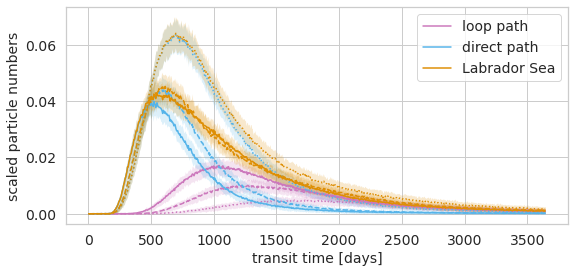

In [50]:
fig,ax = plt.subplots(1,figsize = (9,4),sharex=True)

# plot_hist_curve(ax,h_labcu_1990s,'C1','solid' ,10,'Labrador Sea')
# plot_hist_curve(ax,h_labcu_2000s,'C1','dashed',10)
# plot_hist_curve(ax,h_labcu_2010s,'C1','dotted',10)

plot_hist_curve(ax,h_lc60w_1990s,'C4','solid' ,10,'loop path',ntraj=ntraj_total)
plot_hist_curve(ax,h_lc60w_2000s,'C4','dashed',10,ntraj=ntraj_total)
plot_hist_curve(ax,h_lc60w_2010s,'C4','dotted',10,ntraj=ntraj_total)

plot_hist_curve(ax,h_lcdir_1990s,'C9','solid' ,10,'direct path',ntraj=ntraj_total)
plot_hist_curve(ax,h_lcdir_2000s,'C9','dashed',10,ntraj=ntraj_total)
plot_hist_curve(ax,h_lcdir_2010s,'C9','dotted',10,ntraj=ntraj_total)

plot_hist_curve(ax,h_labcu_1990s,'C1','solid' ,10,'Labrador Sea',ntraj=ntraj_total)
plot_hist_curve(ax,h_labcu_2000s,'C1','dashed',10,ntraj=ntraj_total)
plot_hist_curve(ax,h_labcu_2010s,'C1','dotted',10,ntraj=ntraj_total)


ax.legend()
ax.set_xlabel('transit time [days]')
ax.set_ylabel('scaled particle numbers')


In [52]:
conda list

# packages in environment at /opt/tljh/user/envs/parcels-container_2021.09.29-09ab0ce:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       1_gnu    conda-forge
ansiwrap                  0.8.4                      py_0    conda-forge
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
asciitree                 0.3.3                      py_2    conda-forge
async_generator           1.10                       py_0    conda-forge
attrs                     21.2.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1ab_0    conda-forge
basemap                   1.2.2            py39h523bb60_3    conda-forge
binutils_impl_linux-64    2.36.1     